#  Heart rhythm classification from raw ECG signals

## Table of contents

- 2.0 Extract features from heartbeat templates
- 3.0 Extract features from delineation
- 4.0 Define customised transformers for Pipeline


## Notes
Interesting insights from Nature paper published on 21.9.2021
- https://www.nature.com/articles/s41598-021-97118-5?proof=t%3B#Tab6
- https://www.youtube.com/watch?v=3tfin4sSBFQ
- Focus on only two features PR and RT.
- MLP and SVM


In [74]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import biosppy.signals.ecg as ecg
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
import seaborn as sns
import matplotlib.pyplot as plt
sns.set('talk')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

## Params

In [621]:
sr = 300 #sampling rate
trim_beginning = True
downsampling = True
div_downsampling = 2
sr_down = int(sr/div_downsampling)


# Some matplotlib setting 
plt.rcParams['figure.figsize'] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
#plt.rcParams['axes.labelsize'] = 48
#plt.rcParams['axes.titlesize'] = 48

## Read data

In [3]:
path = '/home/rapwag01/eth/aml/task2/'

In [4]:
df_train = pd.read_csv(path+'X_train.csv')

In [5]:
df_test = pd.read_csv(path+'X_test.csv')

In [6]:
df_target = pd.read_csv(path+'y_train.csv')

## 2.0 

### 2.1 How to use templates from extract_heartbeats function (biosppy lib)?
- choose a sample id
- clean using custom cleaning
- extract heartbeats using biosppy
- plot templates (beats) in a 3x3 grid

In [553]:
# dummy example with trimmed sample 0 and custom cleaning function
sample_id = 0
print(f'sample id {sample_id} has class {df_target.loc[sample_id].y}')

# drop ID
X = df_train.drop('id', axis=1)
signal = X.loc[sample_id].dropna().to_numpy(dtype='float32')
signal_cut = signal[1000:12000]
signals, rpeaks = my_processing(signal_cut, sampling_rate=sr, detrend_method='locreg', \
                              filter_method='neurokit')
signal_clean = signals['ECG_Clean']

# extract beat templates
# returns an array of dim num_beats x length of beat, where each beat has the same length regardless of the sample_id
beats = ecg.extract_heartbeats(signal_clean, rpeaks, sr)['templates'] # returns df with templates and rpeak array (don't need rpeak array again?)
print(f'length of beat template is {len(beats[0])} and beats shape is {beats.shape}')
print('each beat has the same length regardless of sample_id, but there might be more or less beats extracted. Cannot use all beats as feature, need to aggregate.')


sample id 0 has class 0
length of beat template is 180 and beats shape is (44, 180)
each beat has the same length regardless of sample_id, but there might be more or less beats extracted. Cannot use all beats as feature, need to aggregate.


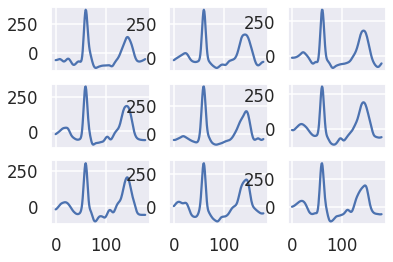

In [179]:
fig, ax = plt.subplots(3,3)
ax[0][0].plot(beats[0])
ax[0][1].plot(beats[1])
ax[0][2].plot(beats[2])
ax[1][0].plot(beats[3])
ax[1][1].plot(beats[4])
ax[1][2].plot(beats[5])
ax[2][0].plot(beats[6])
ax[2][1].plot(beats[7])
ax[2][2].plot(beats[8])

### 2.2. Template-aggregated heartbeat features

In [66]:
mean_beat = np.mean(beats, axis=0)
median_beat = np.median(beats, axis=0)
std_beat = np.std(beats, axis=0)
max_beat = np.max(beats, axis=0)
min_beat = np.min(beats, axis=0)

---

## 3.0 Delineation Features

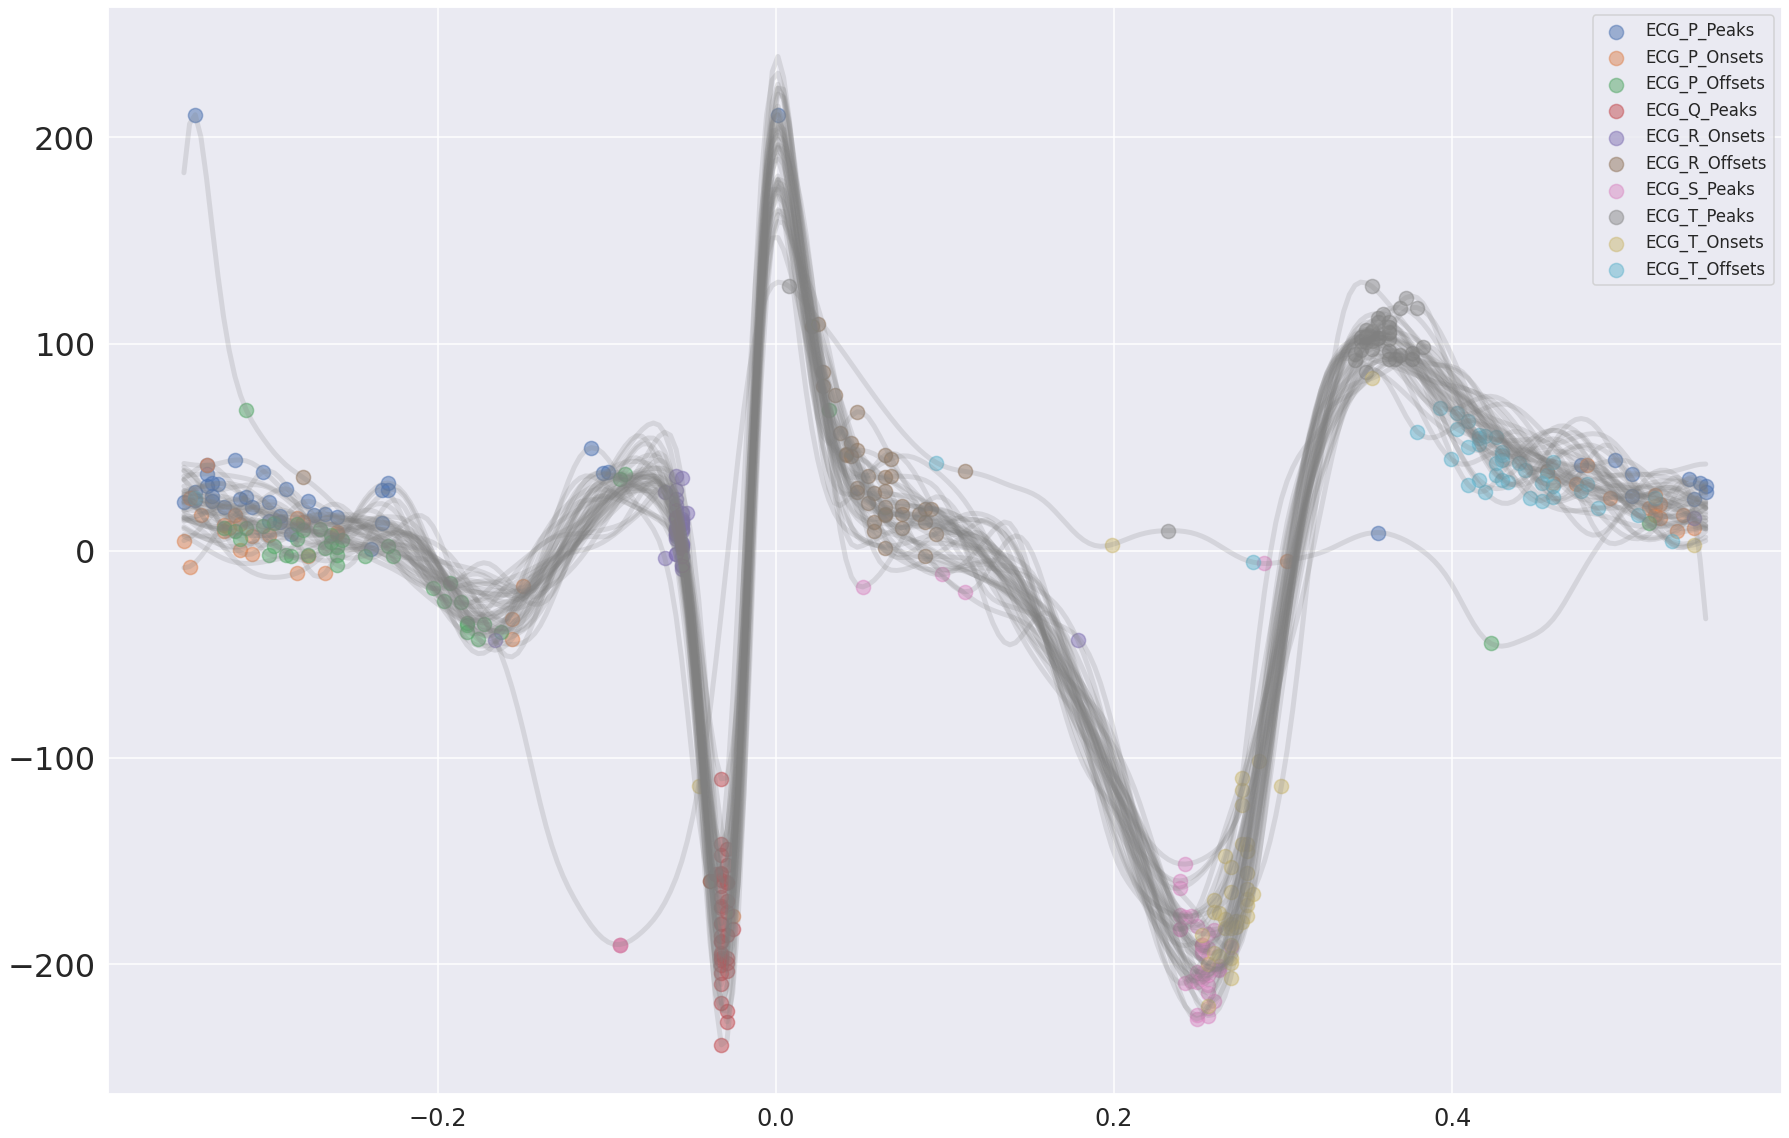

In [11]:
# next to R-peaks, extract P, Q, S and T peaks to get their amplitudes
# use different methods: peak, cwt or dwt
# use wavelet methods to extract QRS on and offsets
_, waves_peak = nk.ecg_delineate(signal_clean, rpeaks, sampling_rate=sr, method="dwt", show=True, show_type='all')

In [14]:
# remove nans
waves_peak_nonan = {k:[elem for elem in v if elem is not np.nan] for k,v in waves_peak.items()}

In [15]:
# should all have the same shape/length
# corrected for nan values
ppeaks = waves_peak_nonan['ECG_P_Peaks']
qpeaks = waves_peak_nonan['ECG_Q_Peaks']
speaks = waves_peak_nonan['ECG_S_Peaks']
tpeaks = waves_peak_nonan['ECG_T_Peaks']
ponsets = waves_peak_nonan['ECG_P_Onsets']
toffsets = waves_peak_nonan['ECG_T_Offsets']

In [19]:
if len(rpeaks) != len(ppeaks):
    print('Warning, peak lengths R and P are different.')

P_amplitudes = signal_clean[ppeaks]
Q_amplitudes = signal_clean[qpeaks]
S_amplitudes = signal_clean[speaks]
T_amplitudes = signal_clean[tpeaks]
R_amplitudes = signal_clean[rpeaks]
Pon_amplitude = signal_clean[ponsets]
Toff_amplitude = signal_clean[toffsets]

Warning, peak lengths R and P are different.


### 3.1 Amplitude Features

In [21]:
# aggregate amplitude values
mean_P_amplitude = np.mean(P_amplitudes)
mean_Q_amplitude = np.mean(Q_amplitudes)
mean_S_amplitude = np.mean(S_amplitudes)
mean_T_amplitude = np.mean(T_amplitudes)
mean_R_amplitude = np.mean(R_amplitudes)

median_P_amplitude = np.median(P_amplitudes)
median_Q_amplitude = np.median(Q_amplitudes)
median_S_amplitude = np.median(S_amplitudes)
median_T_amplitude = np.median(T_amplitudes)
median_R_amplitude = np.median(R_amplitudes)

std_P_amplitude = np.std(P_amplitudes)
std_Q_amplitude = np.std(Q_amplitudes)
std_S_amplitude = np.std(S_amplitudes)
std_T_amplitude = np.std(T_amplitudes)
std_R_amplitude = np.std(R_amplitudes)

max_P_amplitude = np.max(P_amplitudes)
max_Q_amplitude = np.max(Q_amplitudes)
max_S_amplitude = np.max(S_amplitudes)
max_T_amplitude = np.max(T_amplitudes)
max_R_amplitude = np.max(R_amplitudes)

min_P_amplitude = np.min(P_amplitudes)
min_Q_amplitude = np.min(Q_amplitudes)
min_S_amplitude = np.min(S_amplitudes)
min_T_amplitude = np.min(T_amplitudes)
min_R_amplitude = np.min(R_amplitudes)

#these are amplitudes - useless?
mean_pon = np.mean(Pon_amplitude)
median_pon = np.median(Pon_amplitude)
std_pon = np.std(Pon_amplitude)
max_pon = np.max(Pon_amplitude)
min_pon = np.min(Pon_amplitude)

mean_toff = np.mean(Toff_amplitude)
median_toff = np.median(Toff_amplitude)
std_toff = np.std(Toff_amplitude)
max_toff = np.max(Toff_amplitude)
min_toff = np.min(Toff_amplitude)

### 3.2 Timing Features

In [50]:
# normal rr interval 0.6-1.2s
rr_interval = np.diff(rpeaks)/sr*1000 # rr interval in ms

mean_rr_interval = np.mean(rr_interval)
median_rr_interval = np.median(rr_interval)
std_rr_interval = np.std(rr_interval)
max_rr_interval = np.max(rr_interval)
min_rr_interval = np.min(rr_interval)

# pp interval - corrected for nans
pp_interval = np.diff(ppeaks)/sr*1000 # rr interval in ms

mean_pp_interval = np.mean(pp_interval)
median_pp_interval = np.median(pp_interval)
std_pp_interval = np.std(pp_interval)
max_pp_interval = np.max(pp_interval)
min_pp_interval = np.min(pp_interval)

## TO VERIFY IF THIS REALLY IS QRS DURATION!
# qrs duration r-onset minus r onset
qrs_duration = (np.array(waves_peak['ECG_R_Offsets'])-np.array(waves_peak['ECG_R_Onsets']))/sr*1000 # in ms
qrs_duration = qrs_duration[~np.isnan(qrs_duration)]
assert (qrs_duration>0).all()
qrs_mean = np.mean(qrs_duration)
qrs_median = np.median(qrs_duration)
qrs_std = np.std(qrs_duration)
qrs_max = np.max(qrs_duration)
qrs_min = np.min(qrs_duration)

# normal p wave duration 0.12-0.22s
p_duration = (np.array(waves_peak['ECG_P_Offsets'])-np.array(waves_peak['ECG_P_Onsets']))/sr*1000 # in ms
p_duration = p_duration[~np.isnan(p_duration)]
assert (p_duration>0).all()
p_mean = np.mean(p_duration)
p_median = np.median(p_duration)
p_std = np.std(p_duration)
p_max = np.max(p_duration)
p_min = np.min(p_duration)

# pr segment
pr_duration = (np.array(waves_peak['ECG_R_Onsets'])-np.array(waves_peak['ECG_P_Onsets']))/sr*1000 # in ms
pr_duration = pr_duration[~np.isnan(pr_duration)]
assert (pr_duration>0).all()
pr_mean = np.mean(pr_duration)
pr_median = np.median(pr_duration)
pr_std = np.std(pr_duration)
pr_max = np.max(pr_duration)
pr_min = np.min(pr_duration)

# R time
# time from R onset to R peak, R_onset seems to be the QRS onset: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg_delineate%3E
rwave_peaktime = rpeaks-waves_peak['ECG_R_Onsets']
rwave_peaktime = rwave_peaktime[~np.isnan(rwave_peaktime)]
assert (rwave_peaktime>0).all()
rwave_mean = np.mean(rwave_peaktime)
rwave_median = np.median(rwave_peaktime)
rwave_std = np.std(rwave_peaktime)
rwave_max = np.max(rwave_peaktime)
rwave_min = np.min(rwave_peaktime)

---

## 4.0 Customised Transformers for Pipeline

In [214]:
# Classes to extract features from ALL samples

# For each sample:
# 1) process (clean and filter)
# 2) extract heartbeats from clean signal
#     - 180 timestep features for each  beat variable
#     - mean, median, std, max, min
# 3) delineatea and extract amplitude features and extract timing features
# 4) extract hrv
# 5) use in feature union
 
# 1. Cleaning Transformer
# 2. Heartbeat Feature Extractor
# 3. Delineation Extractor
# 4. HRV Extractor


In [596]:
class MyCleaning(BaseEstimator, TransformerMixin):

    def __init__(self, sampling_rate, detrend_method='locreg', filter_method='neurokit', \
                 trim_beginning=True, downsampling=True, skip_num_samples=540, sampling_divisor=2):
        
        self.sr = sampling_rate # sampling rate of original data, *not* after downsampling.
        self.detrend_method = detrend_method
        self.filter_method = filter_method
        self.order = -1
        self.trim_beginning = trim_beginning
        self.skip_num_samples = skip_num_samples # decide how many frames are skipped after starting point of recording
        self.downsampling = downsampling
        self.sampling_divisor = sampling_divisor # decide by how much you want to reduce sampling frequency (divisor)
        

        if self.detrend_method == 'constant':
            self.order = 0
        elif self.detrend_method == 'linear':
            self.order = 1
        elif self.detrend_method == 'quadratic':
            self.order = 2
        elif self.detrend_method == 'cubic':
            self.order = 3
        elif self.detrend_method == 'poly10':
            self.order = 10
        elif self.detrend_method == 'trav':
            self.detrend_method='tarvainen2002'      
        elif self.detrend_method == 'loess':
            self.detrend_method = 'loess'

    
    def fit(self, X, y = None):
        return self

    
    def transform(self, X, y = None):
        """np.apply_along_axis is slower than for loop.
        Keeping for loop."""
        
        if self.trim_beginning:
            X = self._trim_beginning(X)
            
        if self.downsampling:
            X = self._downsampling(X)

        clean_signals = []
        for sample in np.arange(X.shape[0]):
            
            if sample % 500 == 0:
                print(f'cleaning sample {sample}')
            # drop nans
            sample_nonan = X.iloc[sample].dropna().to_numpy(dtype='float32')
            clean = self._cleaning(sample_nonan)
            
            # pad array with nan to match previous dimensions
            pad_width = X.iloc[sample].shape[0]-clean.shape[0]
            cleaned_padded = np.pad(clean, pad_width=(0, pad_width), mode='constant', constant_values=np.nan)           
            clean_signals.append(cleaned_padded)
            
        return np.stack(clean_signals)
    
    def _trim_beginning(self, X):
        """Trim signal at begining and skip n first samples given by skip_num_samples.
        Applied before downsampling if downsampling=True. By default skips ~3 heartbeats, 
        i.e. 3x180 samples, where 180 corresponds to the heartbeat extraction sample size"""
        
        X_trimmed = X[X.columns[self.skip_num_samples:]]
        
        return X_trimmed
    
    def _downsampling(self, X):
        """Selects every n-th (sampling_divisor) timestep.
        By default divides the sampling rate by two."""
        
        X_downsampled = X[X.columns[::self.sampling_divisor]]
        
        print(f'Warning: Changing sampling frequency from {self.sr} to {int(self.sr/self.sampling_divisor)}. Make sure to account for it in later feature extraction steps.')
        
        self.sr = int(self.sr/self.sampling_divisor)
        
        return X_downsampled
    
    def _cleaning(self, raw_ecg):
        """
        For detrending: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend
        For filtering: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
        """

        detrended = nk.signal_detrend(raw_ecg, order=self.order, method=self.detrend_method, \
                                      window=1.5*100, stepsize=0.02*100)        
        
        if self.filter_method == 'custom_butterworth':
            cleaned = nk.signal_filter(detrended, sampling_rate=self.sr, lowcut=2, highcut=9, method='butterworth')
        else:
             # ecg_clean only applies filtering, no detrending
            cleaned = nk.ecg_clean(detrended, sampling_rate=self.sr, method=self.filter_method)

        return cleaned

In [597]:
cleaner = MyCleaning(sampling_rate=sr, detrend_method='locreg', filter_method='neurokit', \
                     downsampling=downsampling, trim_beginning=trim_beginning)

In [428]:
data = df_train.drop('id', axis=1)

In [589]:
t = data[:400]

In [590]:
t.shape

(400, 17842)

In [598]:
%%time
newt = cleaner.fit_transform(t)

cleaning sample 0
CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s


In [600]:
newt.shape

(400, 8651)

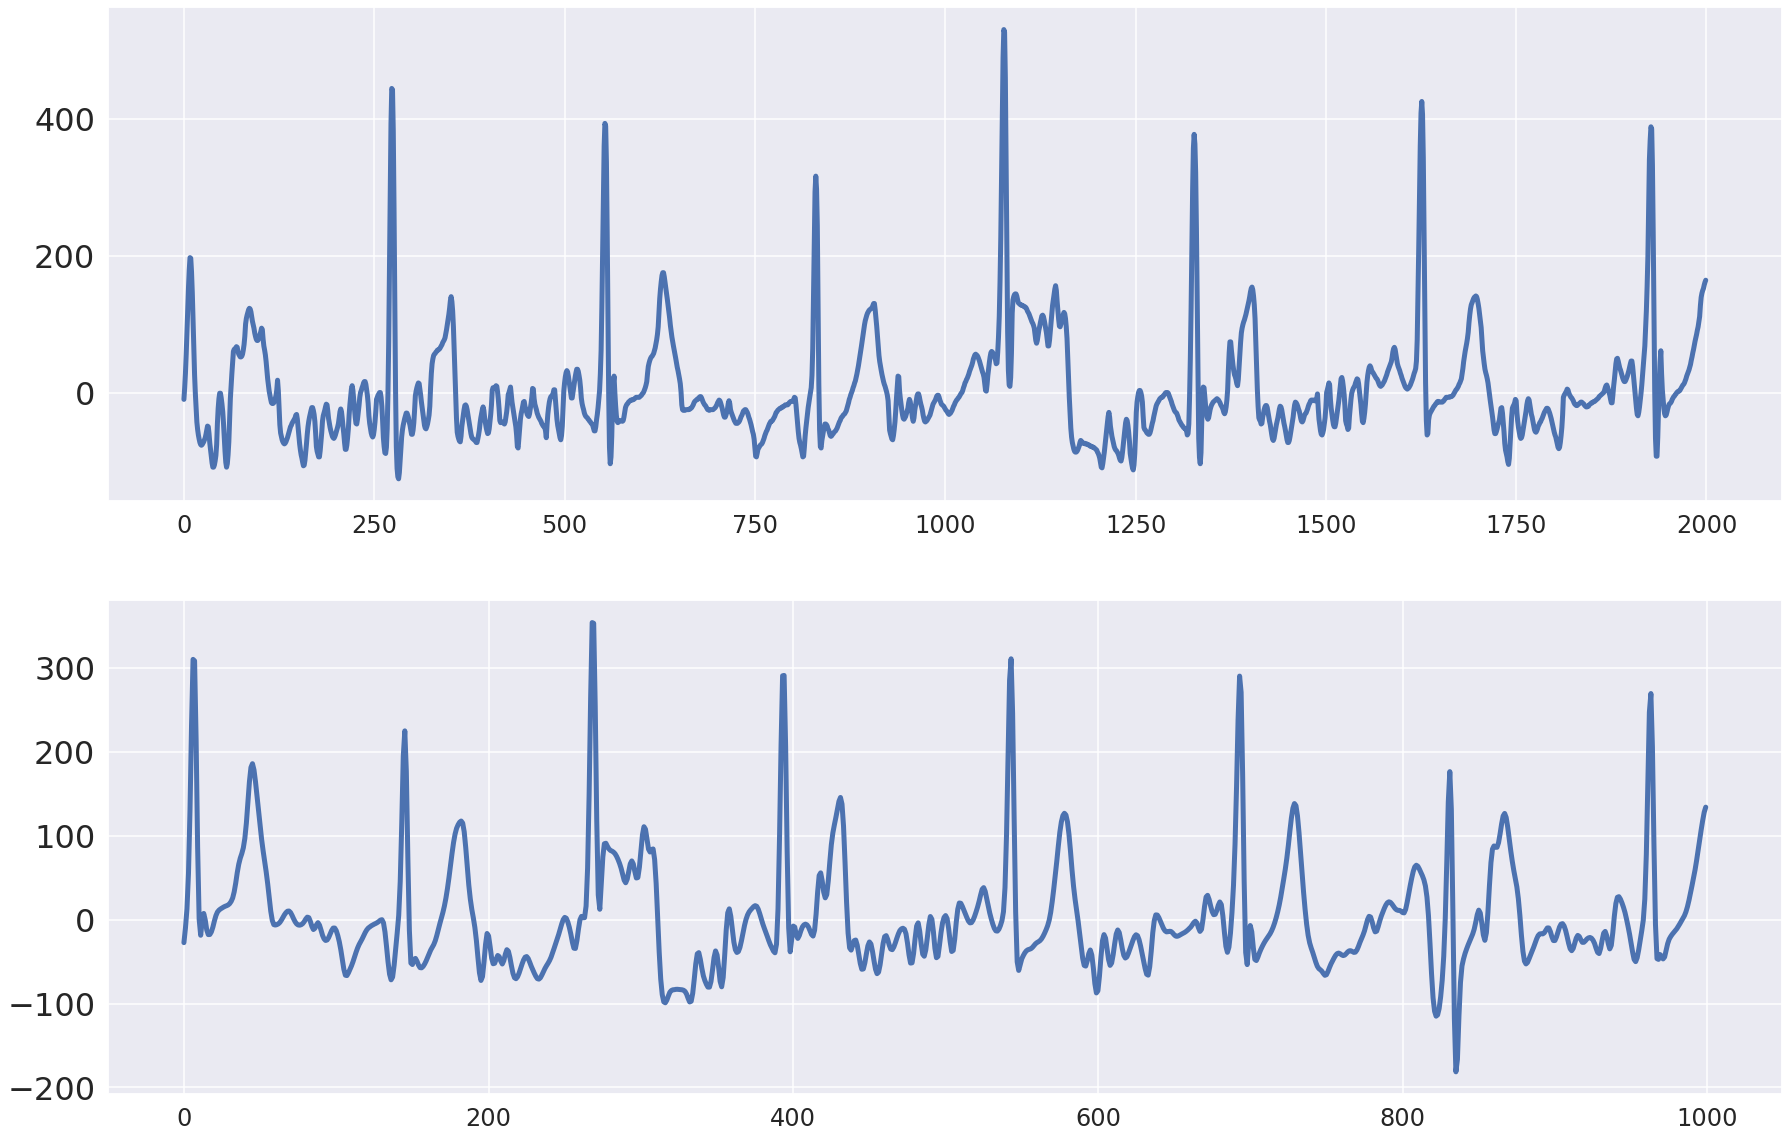

In [615]:
# compare before and after cleaning including trimming and downsampling (/2)
fig, ax = plt.subplots(2,1)
ax[0].plot(t.iloc[88].to_numpy()[:2000])
ax[1].plot(newt[88][:1000])

In [235]:
class MyHeartBeatExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate):
        self.sr = sampling_rate
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        mean_beats = []
        median_beats = []
        std_beats = []
        max_beats = []
        min_beats = []
        rates = []
        
        #features = np.apply_along_axis(self.cleaning, 1, X)
        #_, rpeaks = np.apply_along_axis(self._get_rpeaks(sample_clean)

        for id_clean in np.arange(X.shape[0]):
            if id_clean % 500 == 0:
                print(f'extracting features from sample {id_clean}')
            sample_clean = X[id_clean]

            # get rpeaks
            _, rpeaks = self._get_rpeaks(sample_clean)
            
            # get heartrate as a feature
            rate = self._get_heartrate(rpeaks, sample_clean)
            rates.append(rate)
            
            print(sample_clean)
            # get template for a single sample and aggregate over heartbeats for that single sample
            beats = ecg.extract_heartbeats(sample_clean, rpeaks, self.sr)['templates']
            
            # aggregate over heartbeats
            mean_beat = np.mean(beats, axis=0) # shape (num beats x standard length per beat)
            median_beat = np.median(beats, axis=0)
            std_beat = np.std(beats, axis=0)
            max_beat = np.max(beats, axis=0)
            min_beat = np.min(beats, axis=0)
            
            mean_beats.append(mean_beat)
            median_beats.append(median_beat)
            std_beats.append(std_beat)
            max_beats.append(max_beat)
            min_beats.append(min_beat)
        
        features = [rates, mean_beats, median_beats, std_beats, max_beats, min_beats]
        # should return X_new (num_samples, num_features)
        return np.stack(features)

    def _get_rpeaks(self, ecg_cleaned):

        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=self.sr)
        return instant_peaks, rpeaks
    
    def _get_heartrate(self, rpeaks, ecg_cleaned):
        rate = nk.ecg_rate(rpeaks, sampling_rate=self.sr, desired_length=len(ecg_cleaned))
        return rate
    
    def _get_features_from_sample(self, ecg_cleaned):
        """Returns a list of aggregated heartbeat features for each sample"""
        
        ecg_nonans = ecg_cleaned[~np.isnan(cg_cleaned)]
        _, rpeaks = self._get_rpeaks(ecg_nonans)
        heartrates = self._get_heartrate(rpeaks, ecg_nonans)
        beats = ecg.extract_heartbeats(ecg_nonans, rpeaks, self.sr)['templates']

        # aggregate over heartbeats
        mean_beat = np.mean(beats, axis=0) # shape (num beats x standard length per beat)
        median_beat = np.median(beats, axis=0)
        std_beat = np.std(beats, axis=0)
        max_beat = np.max(beats, axis=0)
        min_beat = np.min(beats, axis=0)
        
        sample_features = [heartrates, mean_beat, median_beat, std_beat, max_beat, min_beat]
        
        return sample_features

In [236]:
beat_extractor = MyHeartBeatExtractor(sampling_rate=sr)

In [241]:
data_clean = cleaner.fit_transform(signal)

cleaning sample 0


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [237]:
features = MyExtractor.fit_transform(signal_clean)

extracting features from sample 0
0        200.601377
1        195.485818
2        190.202530
3        184.762263
4        179.411647
            ...    
16274    -28.738350
16275    -23.297347
16276    -17.126309
16277    -10.425120
16278     -3.404237
Name: 0, Length: 16279, dtype: float64


AxisError: axis -1 is out of bounds for array of dimension 0

In [ ]:
class MyDelineationExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate, delineation_method):
        self.sr = sampling_rate
        self.delineation_method = delineation_method
           
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return 
    
    
    def _get_wavepeaks(self, ecg_cleaned):
        ecg_nonans = ecg_cleaned[~np.isnan(ecg_cleaned)]
        
        _, waves_peak = nk.ecg_delineate(signal_clean, rpeaks, sampling_rate=self.sr, \
                                         method=self.delineation_method, show=False, show_type='all')
        waves_peak_nonan = {k:[elem for elem in v if elem is not np.nan] for k,v in waves_peak.items()}
        
        
        # should all have the same shape/length
        # corrected for nan values
        ppeaks = waves_peak_nonan['ECG_P_Peaks']
        qpeaks = waves_peak_nonan['ECG_Q_Peaks']
        speaks = waves_peak_nonan['ECG_S_Peaks']
        tpeaks = waves_peak_nonan['ECG_T_Peaks']
        ponsets = waves_peak_nonan['ECG_P_Onsets']
        toffsets = waves_peak_nonan['ECG_T_Offsets']
        
        
    

In [626]:
class MyHRVExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate):
        self.sr = sampling_rate    
    
    def _get_hrv(self, ecg_cleaned):
        
        ecg_nonans = ecg_cleaned[~np.isnan(ecg_cleaned)]
        _, rpeaks = nk.ecg_peaks(ecg_nonans, sampling_rate=self.sr)
        
        # TODO fix non-linear hrv extraction with windows issue
        df_hrv_time = nk.hrv_time(rpeaks, sampling_rate=self.sr)
        df_hrv_freq = nk.hrv_frequency(rpeaks, sampling_rate=self.sr)
        df_hrv = pd.concat([df_hrv_time, df_hrv_freq], axis=1)
        return df_hrv.to_numpy()
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        hrvs = []
        for id_clean in np.arange(X.shape[0]):
            if id_clean % 500 == 0:
                print(f'extracting features from sample {id_clean}')
            
            sample_clean = X[id_clean]
            
            hrv = self._get_hrv(sample_clean)
            hrvs.append(hrv)  

        return np.vstack(hrvs)

In [627]:
# TODO sampling rate adjustment
hrv_extractor = MyHRVExtractor(sampling_rate=sr_down)

In [624]:
newt

array([[  31.77431475,   29.04178121,   24.7513355 , ...,           nan,
                  nan,           nan],
       [  15.43808869,   10.57944823,    4.97094345, ...,           nan,
                  nan,           nan],
       [-188.30892145, -192.31537189, -196.46894309, ...,           nan,
                  nan,           nan],
       ...,
       [  20.55101722,   63.36460336,  102.19244937, ...,           nan,
                  nan,           nan],
       [  17.09990458,   12.23268396,    3.28033866, ...,           nan,
                  nan,           nan],
       [ 218.98924098,  216.53699635,  212.56379693, ...,           nan,
                  nan,           nan]])

In [628]:
%%time
hrvt = hrv_extractor.transform(newt)

extracting features from sample 0
CPU times: user 9.77 s, sys: 19.8 ms, total: 9.79 s
Wall time: 9.77 s


---

## Custom Outlier Detector

In [630]:
# custom transformer to two two step classification (class 3 vs all first)
class MyOutlierDetection():
    def __init__(self):
        pass
    def fit(self, X, y):
        pass
    def transform(self, X, y):
        pass

## Build Pipeline

In [ ]:
union = FeatureUnion([('heartbeat', MyHeartBeatExtractor()),
                     ('delineation', MyDelineationExtractor()),
                     ('hrv', MyHRVExtractor())])

In [ ]:
pipeline = Pipeline(
    ('preprocessing', MyPreprocessing),
    ('feature_extraction')
    ('selector', SelectKBest),
    ('umap', ),
    ('classifier', RF with weights)
    )

---

---

In [338]:
# OLD CLEANING CLASS - IGNORE
class MyCleaning(BaseEstimator, TransformerMixin):
    

    def __init__(self, sampling_rate, detrending_method='locreg', filter_method='neurokit'):
        
        self.sr = sampling_rate
        self.detrending_method = detrending_method
        self.filter_method = filter_method
        self.order = -1
        
        if self.detrending_method == 'constant':
            self.order = 0
        elif self.detrending_method == 'linear':
            self.order = 1
        elif self.detrending_method == 'quadratic':
            self.order = 2
        elif self.detrending_method == 'cubic':
            self.order = 3
        elif self.detrending_method == 'poly10':
            self.order = 10
        elif self.detrending_method == 'trav':
            self.detrending_method='tarvainen2002'      
        elif self.detrending_method == 'loess':
            self.detrending_method = 'loess'
        
        print(f'\nSelected detrending method: {self.detrending_method}')
        print(f'Selected filtering method: {self.filter_method}')

    
    def cleaning(self, raw_ecg):
        """
        For detrending: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend
        For filtering: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
        """
        ecg_nonan = raw_ecg[~np.isnan(raw_ecg)]
        
        detrended = nk.signal_detrend(ecg_nonan, order=self.order, method=self.detrending_method, \
                                      window=1.5*100, stepsize=0.02*100)     
        
        
        if self.filter_method == 'custom_butterworth':
            cleaned = nk.signal_filter(detrended, sampling_rate=self.sr, lowcut=2, highcut=9, method='butterworth')
        else:
            cleaned = nk.ecg_clean(detrended, sampling_rate=self.sr, method=self.filter_method) # cleaning only applies filtering, no detrending
        
        # pad array with nan to match previous dimensions
        pad_width = raw_ecg.shape[0]-ecg_nonan.shape[0]
        cleanded_padded = np.pad(cleaned, pad_width=(0, pad_width), mode='constant', constant_values=np.nan)
        
        return cleanded_padded
    

    #estimator method
    def fit(self, X, y=None):
        return self
    
    #transformation
    def transform(self, X, y=None):

        X_new = np.apply_along_axis(self.cleaning, 1, X)
        
        assert X_new.shape[1] == X.shape[1], 'Dimension missmatch of input and output.'
        
        return X_new